In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from tqdm import tqdm
import re

cuda


# Предобработка данных

In [2]:
regex = re.compile(r'^[\d]+_x=([-\d.]+)_z=([-\d.]+)_a=([-\d.]+)_h=([-\d.]+)[.]csv$')

def label_from_path(path):
    label = path.split('\\')[-1] # PLATFORM DEPENDENT!
    m = regex.match(label)
    out = [float(x) for x in m.groups()]
    return torch.tensor(out, dtype=torch.float)

In [3]:
def data_from_path(path):
    data = pd.read_csv(path, sep=';')

    time = data.values[:,0]
    vx   = data.values[:,1::2]
    vz   = data.values[:,2::2]
    vabs = (vx ** 2 + vz ** 2) ** (1/2)
    
    vx   = torch.from_numpy(vx)
    vz   = torch.from_numpy(vz)
    vabs = torch.from_numpy(vabs)
    
    vx_fft   = torch.view_as_real(torch.fft.fft(vx)).permute(2, 0, 1)
    vz_fft   = torch.view_as_real(torch.fft.fft(vz)).permute(2, 0, 1)
    vabs_fft = torch.view_as_real(torch.fft.fft(vabs)).permute(2, 0, 1)

    ret = torch.cat([vx.unsqueeze(0), vz.unsqueeze(0), vabs.unsqueeze(0), vx_fft, vz_fft, vabs_fft], dim=0)

    return ret

### Dataset

In [4]:
class CSVDataset(Dataset):
    def __init__(self, path, device):
        self.device = device
        self.csv_list = [
            (path + "\\" + i) for i in os.listdir(path) if i.split('.')[-1] == 'csv'
        ]

    def __getitem__(self, item):
        d = data_from_path(self.csv_list[item]).to(device=device, dtype=torch.float)
        l = label_from_path(self.csv_list[item]).to(device=device, dtype=torch.float)
        return d, l

    def __len__(self):
        return len(self.csv_list)

### Непосредственно сеть

In [5]:
class Predictor(nn.Module):
    def __init__(self, n_hyper):
        super(Predictor, self).__init__()

        self.feature_extractor = nn.Sequential(
            #        in  out  ker size
            nn.Conv2d(9, n_hyper, 3),     # 9 = len([v_x, v_y, v_abs, 2*fft_vx, 2*fft_vy, 2*fft_vabs, ])
            nn.MaxPool2d(2, 2), 
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(n_hyper),

            nn.Conv2d(n_hyper, 512, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 1024, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),

            nn.Conv2d(1024, 512, 2),
        )

        self.linear = nn.Linear(45, 256)
        self.conv = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.ReLU(inplace=True)
            )

        self.linear2 = nn.Linear(256, 4) # 4 = x, z, a, h

    def forward(self, input):
        x = self.feature_extractor(input)
        x = x.permute(0, 1, 3, 2)
        x = self.linear(x)
        x = self.conv(x)
        x = x.squeeze(1).squeeze(1)
        x = self.linear2(x)

        return x

# Результаты модели

Проводилось 4 эксперимента при различных параметрах n_hyper. Веса сохранялись в папки w1, w2, w3, w4. Первой моделе соответсвует n_hyper = 256, второй n_hyper = 128, третей n_hyper = 64, четвертой n_hyper = 32. Эпохи пронумерованы с 0.


Прогоним модели по тестовым данным и повторим результаты из рисунка 10 и таблицы 3.

In [6]:
def experiment(n, path):
    loss_fn = nn.MSELoss()
    ret = []
    predictor = Predictor(n).to(device)
    
    for fname in [(path + "\\" + i) for i in os.listdir(path)]:
        predictor.load_state_dict(torch.load(fname))
        test_data_loader = DataLoader(CSVDataset(".\\csv_test", device), batch_size=12, shuffle=True)
        total_loss = 0
    
        for data, label in tqdm(test_data_loader):
            with torch.no_grad():
                outputs = predictor(data)
                total_loss += loss_fn(outputs, label)
    
        ret.append((fname, total_loss / len(test_data_loader)))
    
    return ret

In [7]:
def results(ret):
    a = [0, ] * 25
    b = [0, ] * 25

    for x in ret:
        c = int(x[0].split('_')[1])
        a[c] = float(x[0].split('_')[-1])
        b[c] = float(x[1])

    print("Epoch Train loss        Test loss")    
    for x in range(len(a)):
        print(x, "   ", a[x], b[x])


    plt.yscale("log")

    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')

    plt.plot(a)
    plt.plot(b)
    plt.show()

In [12]:
ret = experiment(256, ".//w1")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch Train loss        Test loss
0     45718.42092561849 7059.17529296875
1     4380.993061767578 2958.88232421875
2     2399.6213155110677 2678.343994140625
3     2000.367135172526 1783.60009765625
4     1690.668668294271 1600.6553955078125
5     1477.8920306396485 1070.7567138671875
6     1225.4641667073568 1379.4366455078125
7     1225.8064201049804 1058.3858642578125
8     983.1471684570313 990.8106079101562
9     806.7203869832357 1142.20458984375
10     893.2206697387695 924.6915283203125
11     865.6638067830404 809.701171875
12     675.6369711812338 871.6392211914062
13     644.1288631184896 872.208984375
14     612.9963515421549 772.0078735351562
15     553.7910185750326 631.0411987304688
16     520.0451358846028 512.2998657226562
17     536.1971237080892 557.9710693359375
18     503.4557669474284 625.9976196289062
19     371.2722960611979 424.9783935546875
20     421.7247384033203 563.5158081054688
21     423.6021992085775 487.5791320800781
22     403.09191474405924 412.8110

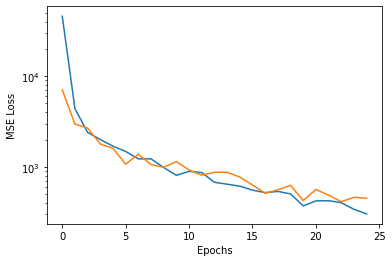

In [24]:
results(ret)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]


Epoch Train loss        Test loss
0     38402.61959065755 5153.2587890625
1     3517.890502766927 2317.1376953125
2     2304.585198852539 2139.88720703125
3     1973.3168083902995 1960.490234375
4     1533.303080037435 1289.9571533203125
5     1339.7622233072916 1397.8038330078125
6     1191.8854018961588 1464.021240234375
7     1098.9046418863932 965.3689575195312
8     1022.8942905476888 1028.228515625
9     887.3866968994141 729.3145751953125
10     860.2220416870117 769.1372680664062
11     885.8546338907878 950.4551391601562
12     631.0371058146159 1104.48876953125
13     651.6892075195312 699.4419555664062
14     698.8807584431967 609.6221313476562
15     637.4185698038737 597.243896484375
16     507.3536002400716 581.1190795898438
17     538.5775926208496 659.812744140625
18     463.34521823120116 633.3958740234375
19     490.6890422973633 486.6031494140625
20     426.86609565226235 441.8855895996094
21     434.7606809285482 385.3861389160156
22     462.1349581604004 680.980285

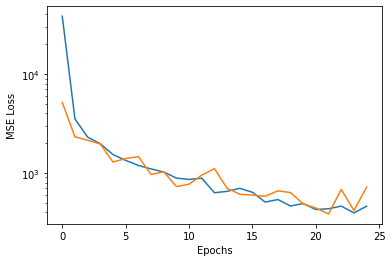

In [28]:
ret = experiment(128, ".//w2")
results(ret)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch Train loss        Test loss
0     37995.8162820638 3892.1474609375
1     3715.439570963542 2762.7490234375
2     2604.4470025227865 2217.5576171875
3     1773.6341033528645 1309.5133056640625
4     1547.2999309895833 3425.950439453125
5     1316.9536556803384 1034.3514404296875
6     1197.787421142578 961.3214111328125
7     1003.76023832194 1024.9617919921875
8     1064.9276525472005 793.57177734375
9     843.9003755289714 679.3629760742188
10     847.6630532633463 1062.745361328125
11     796.7646643676758 505.4977111816406
12     689.7228363647461 1276.1654052734375
13     683.1011740722656 897.5078735351562
14     666.5717091674804 710.8021850585938
15     656.4136258138021 573.3494873046875
16     512.8400864461263 419.4539489746094
17     498.35995985921227 512.0831298828125
18     495.0183553161621 546.957275390625
19     446.92242497762044 428.1332702636719
20     514.0208389282227 455.3475646972656
21     453.59397260538736 574.8724365234375
22     478.74707580566405 361

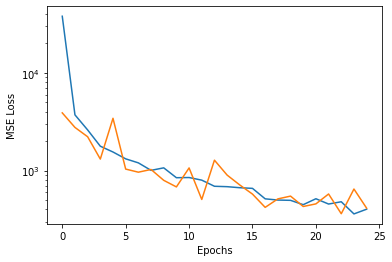

In [29]:
ret = experiment(64, ".//w3")
results(ret)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.19it/s]


Epoch Train loss        Test loss
0     46180.8893523763 5285.19921875
1     4253.4193082682295 4829.3017578125
2     2794.8280506184897 2459.807373046875
3     2159.5597272949217 1838.0948486328125
4     1845.9795686035156 1648.2255859375
5     1666.5838186035157 1782.327880859375
6     1590.0135607503255 1268.1458740234375
7     1248.1552843017578 1900.727783203125
8     1296.2617186279297 2093.595947265625
9     1049.217219543457 1314.161865234375
10     969.7212858479818 1103.1422119140625
11     896.4830109863282 1079.8099365234375
12     907.1207577718098 964.8265991210938
13     753.7879975585937 837.39990234375
14     733.2922454833985 749.7623291015625
15     725.1300467325847 827.7208251953125
16     622.0657198079427 808.1312255859375
17     649.0316087646485 778.7344360351562
18     608.774219136556 652.3377685546875
19     561.3580904947917 852.396484375
20     538.3093043416341 744.796142578125
21     544.007084991455 694.334228515625
22     504.05983953857424 564.1881713

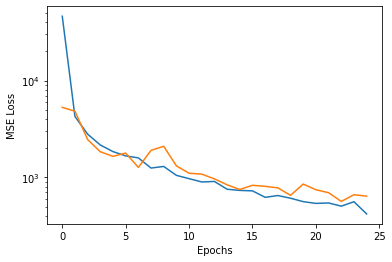

In [30]:
ret = experiment(32, ".//w4")
results(ret)

# Быстрая проверка

Возможно проверить только лучшие эпохи, чтобы ускорить вычисления

In [8]:
def experiment2(n, path, epoch):
    loss_fn = nn.MSELoss()
    ret = []
    predictor = Predictor(n).to(device)
    
    for fname in [(path + "\\" + i) for i in os.listdir(path)]:
        if int(fname.split('_')[1]) == epoch:
            predictor.load_state_dict(torch.load(fname))
            test_data_loader = DataLoader(CSVDataset(".\\csv_test", device), batch_size=8, shuffle=True)
            total_loss = 0
    
            for data, label in tqdm(test_data_loader):
                with torch.no_grad():
                    outputs = predictor(data)
                    total_loss += loss_fn(outputs, label)
    
    return (fname.split('_')[-1], float(total_loss / len(test_data_loader)))

In [9]:
experiment2(256, ".//w1", 22)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:46<00:00,  1.62it/s]


('806.7203869832357', 405.4369812011719)

In [13]:
experiment2(128, ".//w2", 21)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:49<00:00,  1.52it/s]


('887.3866968994141', 407.9442138671875)

In [14]:
experiment2(64, ".//w3", 22)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:48<00:00,  1.53it/s]


('843.9003755289714', 376.24365234375)

In [7]:
experiment2(32, ".//w4", 21)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:55<00:00,  1.34it/s]


('1049.217219543457', 684.9470825195312)

# Сравниваем с const prediction

In [ ]:
x = float(0)
z = float(1100)
a = float(90)
h = float(180)

const_prediction = torch.tensor([x, z, a, h], dtype=torch.float).to(device)

In [ ]:
# Проверка
print(const_prediction)

In [ ]:
test_data_loader = DataLoader(CSVDataset(".\\csv_test", device), batch_size=8, shuffle=True)
loss_fn = nn.MSELoss()

total_loss = 0

for data, label in tqdm(test_data_loader):
    with torch.no_grad():
        total_loss += loss_fn(const_prediction, label)
        
print(total_loss / len(test_data_loader))